In [1]:
import kagglehub
import matplotlib.pyplot as plt
import pandas as pd

C:\Users\matth\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.13_qbz5n2kfra8p0\LocalCache\local-packages\Python313\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Download latest version
path = kagglehub.dataset_download("jacopoferretti/bbc-articles-dataset")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\matth\.cache\kagglehub\datasets\jacopoferretti\bbc-articles-dataset\versions\12


In [3]:
df = pd.read_csv('bbc_data/archive/bbc_text_cls.csv')
df.labels.unique()

array(['business', 'entertainment', 'politics', 'sport', 'tech'],
      dtype=object)

In [4]:
df[(df.duplicated())&(df['labels']=='sports')].duplicated().sum()
dedup = df.drop_duplicates()
print("contains duplicates:", len(df.duplicated().values.nonzero()[0]))
# I don't know why it would contain duplicates, but they are not going to help classification so we drop them
df = dedup

contains duplicates: 98


Create stratified train and test splits, we will investigate the training data.

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['labels'])
df = train_df

In [7]:
print(df.iloc[0]['text'])
# Contains new lines, lets remove them
df_clumped = df.apply(lambda x: x.str.replace('\n\n', '. '))
df_clumped

Hatfield executives go on trial

Engineering firm Balfour Beatty and five railway managers are to go on trial for manslaughter over the Hatfield rail crash in 2000.

Four people died when a section of rail broke and a high speed train derailed. Balfour Beatty's railway maintenance arm was in charge of the upkeep of the line at Hatfield, Hertfordshire. Balfour Beatty managers Anthony Walker and Nicholas Jeffries, and Railtrack managers Alistair Cook, Sean Fugill and Keith Lea all face individual charges. All five men, along with four others, are also accused of breaches of health and safety laws. Balfour Beatty Rail Maintenance faces a corporate manslaughter charge. It is expected the trial could last as long as a year. The accident, on 17 October 2000, happened when the London to Leeds express came off the tracks at 115 mph, when it was derailed by a cracked section of rail. The accident on the East Coast Main Line sparked major disruption. The overall responsibility for the line was R

,text,labels
1073,Hatfield executives go on trial. Engineering f...,politics
1214,MPs tout Lords replacement plan. A group of MP...,politics
141,Asian banks halt dollar's slide. The dollar re...,business
1192,Mandelson warns BBC on Campbell. The BBC shoul...,politics
1599,Laporte tinkers with team. France coach Bernar...,sport
...,...,...
511,Jarre joins fairytale celebration. French musi...,entertainment
1892,'Friends fear' with lost mobiles. People are b...,tech
1284,EU rules 'won't stop UK spending'. The shape o...,politics
85,Manufacturing recovery 'slowing'. UK manufactu...,business


In [8]:
# Check the distribution of labels
df_clumped['labels'].value_counts()

labels
sport            404
business         402
politics         322
entertainment    295
tech             278
Name: count, dtype: int64

Seems like the data is quite balanced, I want to check average text length

In [9]:
df_clumped['text_len'] = df_clumped['text'].apply(lambda x: len(x))

In [10]:
counts = df_clumped['text_len'].value_counts()
max = df_clumped['text_len'].max()
min = df_clumped['text_len'].min()
print("max: ", max)
print("min: ", min)

(max-min) // 8

max:  25484
min:  502


np.int64(3122)

In [11]:
jump_size = 3122
jump_size*9

28098

In [12]:

bins = [0, jump_size, jump_size*2, jump_size*3, jump_size*4, jump_size*5, jump_size*6, jump_size*7]  # Define bucket edges
labels = [f'0-{jump_size}',
          f'{jump_size}-{jump_size*2}',
          f'{jump_size*2}-{jump_size*3}',
          f'{jump_size*3}-{jump_size*4}',
          f'{jump_size*4}-{jump_size*5}',
          f'{jump_size*5}-{jump_size*6}',
          f'{jump_size*6}-{jump_size*7}']  # Define bucket labels
binned_counts = pd.cut(df_clumped['text_len'], bins=bins, labels=labels, right=False)


In [13]:
binned_counts_grouped = binned_counts.value_counts()
binned_counts_grouped

text_len
0-3122         1405
3122-6244       286
6244-9366         5
9366-12488        1
12488-15610       1
15610-18732       1
18732-21854       1
Name: count, dtype: int64

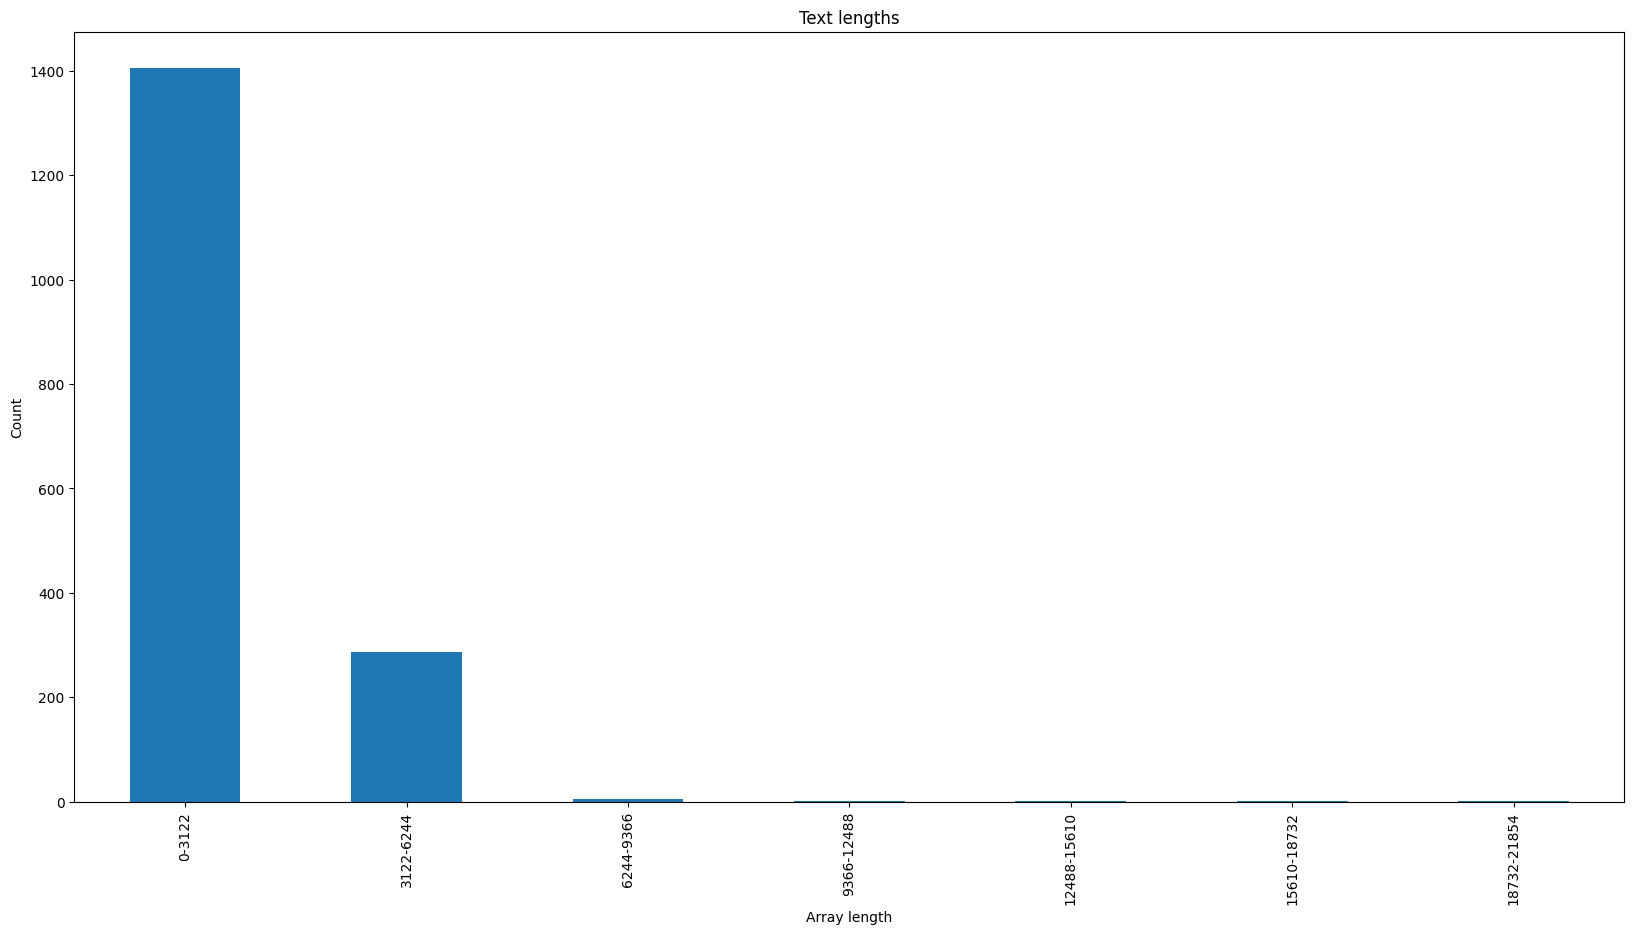

In [14]:
binned_counts_grouped.plot(kind='bar', figsize=(20, 10), title='Text lengths')
plt.xlabel('Array length')
plt.ylabel('Count')
plt.show()

Word count is scewed with a handful or big outliers, this might scew things

Lets apply stopword and alphanumeric removal first then try stemming and lemmatisation to reduce the noise in the dataset.
Stemming and lemmmatisation should compress the data differently, with lemmatisation being more aggressive.
Even the smallest text is quite long so we should be able to apply these functions without losing all meaning of the text.
I will create each, then vectorise and split into train and val before training a neural network.

In [15]:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('punkt_tab')
stop_words = set(stopwords.words('english'))

from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
nltk.download('averaged_perceptron_tagger_eng')
#nltk.download('wordnet')
lemmer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     C:\Users\matth\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!


In [16]:
df.loc[0]['text']

'Ad sales boost Time Warner profit\n\nQuarterly profits at US media giant TimeWarner jumped 76% to $1.13bn (£600m) for the three months to December, from $639m year-earlier.\n\nThe firm, which is now one of the biggest investors in Google, benefited from sales of high-speed internet connections and higher advert sales. TimeWarner said fourth quarter sales rose 2% to $11.1bn from $10.9bn. Its profits were buoyed by one-off gains which offset a profit dip at Warner Bros, and less users for AOL.\n\nTime Warner said on Friday that it now owns 8% of search-engine Google. But its own internet business, AOL, had has mixed fortunes. It lost 464,000 subscribers in the fourth quarter profits were lower than in the preceding three quarters. However, the company said AOL\'s underlying profit before exceptional items rose 8% on the back of stronger internet advertising revenues. It hopes to increase subscribers by offering the online service free to TimeWarner internet customers and will try to sig

In [17]:
tokenised = nltk.word_tokenize(df.loc[0]['text'])

In [18]:
print(f"isalnum: ", [token for token in tokenised if token.isalnum()])
print(f"stopword removed: ", [token for token in tokenised if token.lower() not in stop_words])

isalnum:  ['Ad', 'sales', 'boost', 'Time', 'Warner', 'profit', 'Quarterly', 'profits', 'at', 'US', 'media', 'giant', 'TimeWarner', 'jumped', '76', 'to', 'for', 'the', 'three', 'months', 'to', 'December', 'from', '639m', 'The', 'firm', 'which', 'is', 'now', 'one', 'of', 'the', 'biggest', 'investors', 'in', 'Google', 'benefited', 'from', 'sales', 'of', 'internet', 'connections', 'and', 'higher', 'advert', 'sales', 'TimeWarner', 'said', 'fourth', 'quarter', 'sales', 'rose', '2', 'to', 'from', 'Its', 'profits', 'were', 'buoyed', 'by', 'gains', 'which', 'offset', 'a', 'profit', 'dip', 'at', 'Warner', 'Bros', 'and', 'less', 'users', 'for', 'AOL', 'Time', 'Warner', 'said', 'on', 'Friday', 'that', 'it', 'now', 'owns', '8', 'of', 'Google', 'But', 'its', 'own', 'internet', 'business', 'AOL', 'had', 'has', 'mixed', 'fortunes', 'It', 'lost', 'subscribers', 'in', 'the', 'fourth', 'quarter', 'profits', 'were', 'lower', 'than', 'in', 'the', 'preceding', 'three', 'quarters', 'However', 'the', 'company

In [19]:
# Remove stopwords and non alphanumeric tokens
def make_concise(text):
    tokenised = nltk.word_tokenize(text)
    concise_text = [token for token in tokenised if token.isalnum() and token.lower() not in stop_words]
    return concise_text

df['cleaned_text'] = df['text'].apply(lambda x: make_concise(x))
df['cleaned_text']

1073    [Hatfield, executives, go, trial, Engineering,...
1214    [MPs, tout, Lords, replacement, plan, group, M...
141     [Asian, banks, halt, dollar, slide, dollar, re...
1192    [Mandelson, warns, BBC, Campbell, BBC, steer, ...
1599    [Laporte, tinkers, team, France, coach, Bernar...
                              ...                        
511     [Jarre, joins, fairytale, celebration, French,...
1892    [fear, lost, mobiles, People, becoming, depend...
1284    [EU, rules, stop, UK, spending, shape, UK, eco...
85      [Manufacturing, recovery, UK, manufacturing, g...
324     [Indy, buys, India, paper, Irish, publishing, ...
Name: cleaned_text, Length: 1701, dtype: object

In [20]:
# Quickly check we haven't got any text that is crazy short now
df['cleaned_text_len'] = df['cleaned_text'].apply(lambda x: len(x))
print(f"min length: ", df['cleaned_text_len'].min())

min length:  47


47 isn't too bad, the dataset is probably quite imbalanced tho. I wonder if this affects the tf-idf encoding.
It might mean big documents fit into multiple categories?

Create the stemmatised version

In [21]:
# Take cleaned text and apply stemming and lemmatisation separately
def stem(cleaned_text):
    # I call words in the cleaned text as tokens because it is a better descriptor at this point
    stemmed = [stemmer.stem(token) for token in cleaned_text]
    return stemmed

df['stemmed'] = df['cleaned_text'].apply(lambda x: stem(x))
df['stemmed']

1073    [hatfield, execut, go, trial, engin, firm, bal...
1214    [mp, tout, lord, replac, plan, group, mp, tri,...
141     [asian, bank, halt, dollar, slide, dollar, reg...
1192    [mandelson, warn, bbc, campbel, bbc, steer, aw...
1599    [laport, tinker, team, franc, coach, bernard, ...
                              ...                        
511     [jarr, join, fairytal, celebr, french, musicia...
1892    [fear, lost, mobil, peopl, becom, depend, mobi...
1284    [eu, rule, stop, uk, spend, shape, uk, economi...
85      [manufactur, recoveri, uk, manufactur, grew, s...
324     [indi, buy, india, paper, irish, publish, grou...
Name: stemmed, Length: 1701, dtype: object

Create the lemmatised version

In [22]:
print(pos_tag(df['cleaned_text'].loc[0]))

[('Ad', 'NN'), ('sales', 'NNS'), ('boost', 'VBP'), ('Time', 'NNP'), ('Warner', 'NNP'), ('profit', 'VB'), ('Quarterly', 'JJ'), ('profits', 'NNS'), ('US', 'IN'), ('media', 'NNS'), ('giant', 'JJ'), ('TimeWarner', 'NNP'), ('jumped', 'VBD'), ('76', 'CD'), ('three', 'CD'), ('months', 'NNS'), ('December', 'NNP'), ('639m', 'CD'), ('firm', 'NN'), ('one', 'CD'), ('biggest', 'JJS'), ('investors', 'NNS'), ('Google', 'NNP'), ('benefited', 'VBD'), ('sales', 'NNS'), ('internet', 'NN'), ('connections', 'NNS'), ('higher', 'RBR'), ('advert', 'JJ'), ('sales', 'NNS'), ('TimeWarner', 'NNP'), ('said', 'VBD'), ('fourth', 'JJ'), ('quarter', 'NN'), ('sales', 'NNS'), ('rose', 'VBD'), ('2', 'CD'), ('profits', 'NNS'), ('buoyed', 'VBD'), ('gains', 'NNS'), ('offset', 'VB'), ('profit', 'NN'), ('dip', 'NN'), ('Warner', 'NNP'), ('Bros', 'NNP'), ('less', 'JJR'), ('users', 'NNS'), ('AOL', 'NNP'), ('Time', 'NNP'), ('Warner', 'NNP'), ('said', 'VBD'), ('Friday', 'NNP'), ('owns', 'VBZ'), ('8', 'CD'), ('Google', 'NNP'), ('in

In [23]:
# Take cleaned text and apply stemming and lemmatisation separately
def lemm(cleaned_text):
    # I call words in the cleaned text as tokens because it is a better descriptor at this point
    tagged_tokens = pos_tag(cleaned_text)

    lemmed_tokens = []
    # Add some extra detail
    for word, tag in tagged_tokens:
        if tag.startswith('V'):
            pos = 'v'
        elif tag.startswith('N'):
            pos = 'n'
        elif tag.startswith('J'):
            pos = 'a'
        else:
            pos = 'n'
        lemmed_tokens.append(lemmer.lemmatize(word, pos=pos))
    return lemmed_tokens

df['lemmed'] = df['cleaned_text'].apply(lambda x: lemm(x))
df['lemmed']

1073    [Hatfield, executive, go, trial, Engineering, ...
1214    [MPs, tout, Lords, replacement, plan, group, M...
141     [Asian, bank, halt, dollar, slide, dollar, reg...
1192    [Mandelson, warn, BBC, Campbell, BBC, steer, a...
1599    [Laporte, tinker, team, France, coach, Bernard...
                              ...                        
511     [Jarre, join, fairytale, celebration, French, ...
1892    [fear, lose, mobile, People, become, dependent...
1284    [EU, rule, stop, UK, spending, shape, UK, econ...
85      [Manufacturing, recovery, UK, manufacturing, g...
324     [Indy, buy, India, paper, Irish, publishing, g...
Name: lemmed, Length: 1701, dtype: object

Lets start applying tf-idf to these separate experiments
I will call the vectors td_idf_base, tf_idf_stem and tf_idf_lemm, where base is just alphnum and stop word actions

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Apply tfidf vectorising to the cleaned text and call it the base
vectoriser = TfidfVectorizer()
tf_idf_base = vectoriser.fit_transform(df['cleaned_text'].apply(lambda x: ' '.join(x)))

# Convert the tf-idf data to a dataframe
tf_idf_base_df = pd.DataFrame({'tfidf': tf_idf_base.toarray().tolist()}, index=df.index)

In [25]:
# Apply tfidf vectorising to stemmed text
tf_idf_stem = vectoriser.fit_transform(df['stemmed'].apply(lambda x: ' '.join(x)))

# Convert the tf-idf data to a dataframe
tf_idf_stem_df = pd.DataFrame({'tfidf': tf_idf_stem.toarray().tolist()}, index=df.index)

In [26]:
# Apply tfidf vectorising to stemmed text
tf_idf_stem = vectoriser.fit_transform(df['lemmed'].apply(lambda x: ' '.join(x)))

# Convert the tf-idf data to a dataframe
tf_idf_stem_df = pd.DataFrame({'tfidf': tf_idf_stem.toarray().tolist()}, index=df.index)

Create neural network for training

In [28]:
import numpy as np
X = np.array(tf_idf_base_df['tfidf'].tolist())
y = df['labels'].astype('category').cat.codes.values

In [29]:
# Split into training and validation
x_train, x_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [30]:
import torch
from torch.nn import Module, Linear, ReLU, Softmax

class NewsClassifierNN(Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NewsClassifierNN, self).__init__()
        self.fc1 = Linear(input_size, hidden_size)
        self.relu = ReLU()
        self.fc2 = Linear(hidden_size, output_size)
        self.softmax = Softmax(dim=1)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.softmax(out)
        return out


input_size = len(tf_idf_base_df.loc[0].item())
hidden_size = 128
output_size = len(df['labels'].unique())
model = NewsClassifierNN(input_size, hidden_size, output_size)
print(model)

NewsClassifierNN(
  (fc1): Linear(in_features=25804, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=5, bias=True)
  (softmax): Softmax(dim=1)
)


In [31]:
opt = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = torch.nn.CrossEntropyLoss()

In [32]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(x_train, y_train)
batch_size = 32
loader = DataLoader(dataset, batch_size, shuffle=True)
for epoch in range(10):
    for inputs, labels in loader:
        inputs = inputs.float()
        labels = labels.long()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimization
        opt.zero_grad()
        loss.backward()
        opt.step()

    print(f'Epoch [{epoch+1}/10], Loss: {loss.item():.4f}')

TypeError: 'int' object is not callable

In [ ]:
from sklearn.svm import SVC

# Build the model
svm = SVC(kernel="rbf", gamma=0.5, C=1.0)
svm.fit(X, y)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,0.5
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


In [ ]:
import joblib

joblib.dump(svm, 'svm_base.pkl')

['svm_base.pkl']

In [ ]:
# Apply stop word removal and alnum check to test set
def make_concise_test(text):
    tokenised = nltk.word_tokenize(text)
    concise_text = [token for token in tokenised if token.isalnum() and token.lower() not in stop_words]
    return concise_text

test_df['cleaned_text'] = test_df['text'].apply(lambda x: make_concise_test(x))
test_df['cleaned_text']

2123    [Apple, Mac, mini, gets, warm, welcome, Mac, m...
612     [Downloads, enter, US, singles, chart, Digital...
1701    [Dallaglio, eyeing, Lions, tour, place, Former...
796     [REM, announce, new, Glasgow, concert, US, ban...
1134    [Row, power, CSOs, Police, Federation, said, s...
                              ...                        
1128    [ready, information, act, Thousands, public, b...
1897    [China, overtake, US, net, use, Chinese, popul...
1170    [Howard, dismisses, Tory, tax, fears, Michael,...
272     [Markets, fall, weak, dollar, fears, Rising, o...
787     [Download, chart, debut, delayed, inclusion, d...
Name: cleaned_text, Length: 426, dtype: object

In [ ]:

svm.predict(X[0].reshape(1, -1))